In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import classification_report, accuracy_score

# =================== CONFIG ===================
data_dir = r"E:\Collaboration Work\With Farooq\Bearings MDPI\CWT_Log\For Channel-02"
batch_size = 32
num_epochs = 40
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ================== TRANSFORMS =================
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

# ================ LOAD DATA ===================
full_dataset = datasets.ImageFolder(data_dir, transform=transform)
targets = [label for _, label in full_dataset.samples]

splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_idx, val_idx in splitter.split(torch.zeros(len(targets)), targets):
    train_dataset = Subset(full_dataset, train_idx)
    val_dataset = Subset(full_dataset, val_idx)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# =============== MODEL WITHOUT BiLSTM ===============
class Hybrid_No_BiLSTM(nn.Module):
    def __init__(self, input_channels=1, num_classes=4):
        super(Hybrid_No_BiLSTM, self).__init__()
        self.conv_block = nn.Sequential(
            nn.Conv1d(input_channels, 64, kernel_size=7, padding=3),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
            nn.Conv1d(64, 128, kernel_size=5, padding=2),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2)
        )
        self.mhsa = nn.MultiheadAttention(embed_dim=128, num_heads=4, batch_first=True)
        self.classifier = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):  # x: (B, 1, 128, 128)
        x = torch.mean(x, dim=2)        # → (B, 1, 128) — avg over freq axis (dim=2)
        x = self.conv_block(x)          # → (B, 128, T)
        x = x.permute(0, 2, 1)          # → (B, T, 128)
        x, _ = self.mhsa(x, x, x)       # → MHSA output
        x = x.mean(dim=1)               # → Global Average Pooling
        x = self.classifier(x)          # → Output logits
        return x

# =============== INIT + TRAINING ===============
model = Hybrid_No_BiLSTM(input_channels=1, num_classes=len(full_dataset.classes)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

for epoch in range(num_epochs):
    model.train()
    total_loss, correct, total = 0.0, 0, 0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == batch_y).sum().item()
        total += batch_y.size(0)
    train_acc = 100 * correct / total
    scheduler.step()
    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {total_loss:.4f}, Train Acc: {train_acc:.2f}%")

# ============== EVALUATION ====================
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for batch_X, batch_y in val_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        outputs = model(batch_X)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(batch_y.cpu().numpy())

acc = accuracy_score(all_labels, all_preds)
print(f"\n✅ Final Validation Accuracy: {acc * 100:.2f}%")
print("\n=== Classification Report ===")
print(classification_report(all_labels, all_preds, target_names=full_dataset.classes))


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import numpy as np

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
labels = full_dataset.classes

# Plot
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels,
            annot_kws={"size": 16, "weight": "bold"})
plt.title('Confusion Matrix', fontsize=18, fontweight='bold')
plt.xlabel('Predicted', fontsize=16, fontweight='bold')
plt.ylabel('True', fontsize=16, fontweight='bold')
plt.xticks(fontsize=12, weight='bold', rotation=45)
plt.yticks(fontsize=12, weight='bold',rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# ==== Extract Features for t-SNE ====
model.eval()
features, tsne_labels = [], []

with torch.no_grad():
    for batch_X, batch_y in val_loader:
        batch_X = batch_X.to(device)

        # Forward pass up to MHSA layer (before classifier)
        x = torch.mean(batch_X, dim=2)       # (B, 1, 128) – freq axis avg
        x = model.conv_block(x)              # → (B, 128, T)
        x = x.permute(0, 2, 1)               # → (B, T, 128)
        x, _ = model.mhsa(x, x, x)           # → (B, T, 128)
        x = x.mean(dim=1)                    # → Global Avg Pooling (B, 128)
        features.append(x.cpu().numpy())
        tsne_labels.extend(batch_y.cpu().numpy())

features_np = np.concatenate(features, axis=0)  # (N, 128)
tsne_labels = np.array(tsne_labels)             # (N,)
print("✅ Extracted Features Shape:", features_np.shape)

# ==== Apply t-SNE ====
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, n_iter=1000, random_state=42)
features_2d = tsne.fit_transform(features_np)

# ==== Plot t-SNE ====
plt.figure(figsize=(10, 8))
palette = sns.color_palette("tab10", len(set(tsne_labels)))

for i, label in enumerate(np.unique(tsne_labels)):
    idx = tsne_labels == label
    plt.scatter(
        features_2d[idx, 0], features_2d[idx, 1],
        label=f"{full_dataset.classes[label]}",
        s=100
    )

plt.xlabel("t-SNE Component 1", fontsize=16, fontweight='bold')
plt.ylabel("t-SNE Component 2", fontsize=16, fontweight='bold')
plt.legend(title="Classes", fontsize=13, title_fontsize=14)

plt.xticks(fontsize=12, weight='bold')
plt.yticks(fontsize=12, weight='bold')
plt.tight_layout()

plt.show()


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import classification_report, accuracy_score

# ========== CONFIG ==========
data_dir = r"E:\Collaboration Work\With Farooq\Bearings MDPI\CWT_Log\For Channel-02"
batch_size = 32
num_epochs = 40
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ========== TRANSFORMS ==========
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

# ========== LOAD DATA ==========
full_dataset = datasets.ImageFolder(data_dir, transform=transform)
targets = [label for _, label in full_dataset.samples]

splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_idx, val_idx in splitter.split(torch.zeros(len(targets)), targets):
    train_dataset = Subset(full_dataset, train_idx)
    val_dataset = Subset(full_dataset, val_idx)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# ========== MODEL (No MHSA) ==========
class Hybrid_No_MHSA(nn.Module):
    def __init__(self, input_channels=1, num_classes=4):
        super(Hybrid_No_MHSA, self).__init__()
        self.conv_block = nn.Sequential(
            nn.Conv1d(input_channels, 64, kernel_size=7, padding=3),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
            nn.Conv1d(64, 128, kernel_size=5, padding=2),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2)
        )
        self.bilstm = nn.LSTM(input_size=128, hidden_size=64, num_layers=1, 
                              batch_first=True, bidirectional=True)
        self.classifier = nn.Sequential(
            nn.Linear(64 * 2, 64),  # BiLSTM has 2 directions
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):  # x: (B, 1, 128, 128)
        x = torch.mean(x, dim=2)        # → (B, 1, 128)
        x = self.conv_block(x)          # → (B, 128, T)
        x = x.permute(0, 2, 1)          # → (B, T, 128)
        x, _ = self.bilstm(x)           # → (B, T, 128)
        x = x.mean(dim=1)               # → (B, 128)
        x = self.classifier(x)          # → (B, num_classes)
        return x

# ========== TRAINING ==========
model = Hybrid_No_MHSA(input_channels=1, num_classes=len(full_dataset.classes)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

for epoch in range(num_epochs):
    model.train()
    total_loss, correct, total = 0.0, 0, 0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == batch_y).sum().item()
        total += batch_y.size(0)
    train_acc = 100 * correct / total
    scheduler.step()
    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {total_loss:.4f}, Train Acc: {train_acc:.2f}%")

# ========== EVALUATION ==========
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for batch_X, batch_y in val_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        outputs = model(batch_X)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(batch_y.cpu().numpy())

acc = accuracy_score(all_labels, all_preds)
print(f"\n✅ Final Validation Accuracy: {acc * 100:.2f}%")
print("\n=== Classification Report ===")
print(classification_report(all_labels, all_preds, target_names=full_dataset.classes))


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
labels = full_dataset.classes

# Plot
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels,
            annot_kws={"size": 16, "weight": "bold"})
plt.title("Confusion Matrix", fontsize=18, fontweight='bold')
plt.xlabel("Predicted", fontsize=16, fontweight='bold')
plt.ylabel("True", fontsize=16, fontweight='bold')
plt.xticks(fontsize=12, weight='bold', rotation=45)
plt.yticks(fontsize=12, weight='bold', rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.manifold import TSNE
import numpy as np

# Extract features before classifier
model.eval()
features, tsne_labels = [], []

with torch.no_grad():
    for batch_X, batch_y in val_loader:
        batch_X = batch_X.to(device)

        # Forward pass till BiLSTM (just before classifier)
        x = torch.mean(batch_X, dim=2)       # (B, 1, 128)
        x = model.conv_block(x)              # → (B, 128, T)
        x = x.permute(0, 2, 1)               # → (B, T, 128)
        x, _ = model.bilstm(x)               # → (B, T, 128)
        x = x.mean(dim=1)                    # → (B, 128)
        features.append(x.cpu().numpy())
        tsne_labels.extend(batch_y.cpu().numpy())

features_np = np.concatenate(features, axis=0)
tsne_labels = np.array(tsne_labels)
print("✅ Features Shape for t-SNE:", features_np.shape)

# Apply t-SNE
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, n_iter=1000, random_state=42)
features_2d = tsne.fit_transform(features_np)

# Plot t-SNE
plt.figure(figsize=(10, 8))
palette = sns.color_palette("tab10", len(set(tsne_labels)))

for i, label in enumerate(np.unique(tsne_labels)):
    idx = tsne_labels == label
    plt.scatter(
        features_2d[idx, 0], features_2d[idx, 1],
        label=f"{full_dataset.classes[label]}",
        s=100
    )


plt.xlabel("t-SNE Component 1", fontsize=16, fontweight='bold')
plt.ylabel("t-SNE Component 2", fontsize=16, fontweight='bold')
plt.legend(title="Classes", fontsize=12, title_fontsize=13)

plt.xticks(fontsize=12, weight='bold')
plt.yticks(fontsize=12, weight='bold')
plt.tight_layout()

plt.show()


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import classification_report, accuracy_score

# ========== CONFIG ==========
data_dir = r"E:\Collaboration Work\With Farooq\Bearings MDPI\CWT_Log\For Channel-02"
batch_size = 32
num_epochs = 30
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ========== TRANSFORMS ==========
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

# ========== LOAD DATA ==========
full_dataset = datasets.ImageFolder(data_dir, transform=transform)
targets = [label for _, label in full_dataset.samples]

splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_idx, val_idx in splitter.split(torch.zeros(len(targets)), targets):
    train_dataset = Subset(full_dataset, train_idx)
    val_dataset = Subset(full_dataset, val_idx)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# ========== MODEL (No Conv1D) ==========
class Hybrid_No_Conv1D(nn.Module):
    def __init__(self, input_dim=128, num_classes=4, embed_dim=128, num_heads=4):
        super(Hybrid_No_Conv1D, self).__init__()
        self.embedding = nn.Linear(input_dim, embed_dim)  # Embed 128 → 128
        self.mhsa = nn.MultiheadAttention(embed_dim=embed_dim, num_heads=num_heads, batch_first=True)
        self.bilstm = nn.LSTM(input_size=embed_dim, hidden_size=64, batch_first=True, bidirectional=True)
        self.classifier = nn.Sequential(
            nn.Linear(64 * 2, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):  # x: (B, 1, 128, 128)
        x = x.squeeze(1)         # → (B, 128, 128)
        x = self.embedding(x)    # → (B, 128, 128)
        attn_output, _ = self.mhsa(x, x, x)  # → (B, 128, 128)
        lstm_out, _ = self.bilstm(attn_output)  # → (B, 128, 128)
        pooled = lstm_out.mean(dim=1)        # → (B, 128)
        return self.classifier(pooled)       # → (B, num_classes)

# ========== TRAIN ==========
model = Hybrid_No_Conv1D(num_classes=len(full_dataset.classes)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

for epoch in range(num_epochs):
    model.train()
    total_loss, correct, total = 0.0, 0, 0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == batch_y).sum().item()
        total += batch_y.size(0)
    train_acc = 100 * correct / total
    scheduler.step()
    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {total_loss:.4f}, Train Acc: {train_acc:.2f}%")

# ========== EVALUATION ==========
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for batch_X, batch_y in val_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        outputs = model(batch_X)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(batch_y.cpu().numpy())

acc = accuracy_score(all_labels, all_preds)
print(f"\n✅ Final Validation Accuracy: {acc * 100:.2f}%")
print("\n=== Classification Report ===")
print(classification_report(all_labels, all_preds, target_names=full_dataset.classes))


Epoch [1/30] - Train Loss: 48.6212, Train Acc: 25.18%
Epoch [2/30] - Train Loss: 48.4852, Train Acc: 25.09%
Epoch [3/30] - Train Loss: 48.5914, Train Acc: 24.18%
Epoch [4/30] - Train Loss: 47.7637, Train Acc: 31.57%
Epoch [5/30] - Train Loss: 44.8627, Train Acc: 39.51%
Epoch [6/30] - Train Loss: 40.5841, Train Acc: 45.71%
Epoch [7/30] - Train Loss: 36.2497, Train Acc: 54.65%
Epoch [8/30] - Train Loss: 31.2705, Train Acc: 62.41%
Epoch [9/30] - Train Loss: 30.5033, Train Acc: 60.77%
Epoch [10/30] - Train Loss: 25.1425, Train Acc: 68.61%
Epoch [11/30] - Train Loss: 19.4135, Train Acc: 75.82%
Epoch [12/30] - Train Loss: 16.3989, Train Acc: 78.56%
Epoch [13/30] - Train Loss: 18.4011, Train Acc: 74.45%
Epoch [14/30] - Train Loss: 15.4348, Train Acc: 78.92%
Epoch [15/30] - Train Loss: 13.2203, Train Acc: 84.67%
Epoch [16/30] - Train Loss: 10.7382, Train Acc: 88.96%
Epoch [17/30] - Train Loss: 9.2648, Train Acc: 92.15%
Epoch [18/30] - Train Loss: 11.0255, Train Acc: 87.96%
Epoch [19/30] - Trai

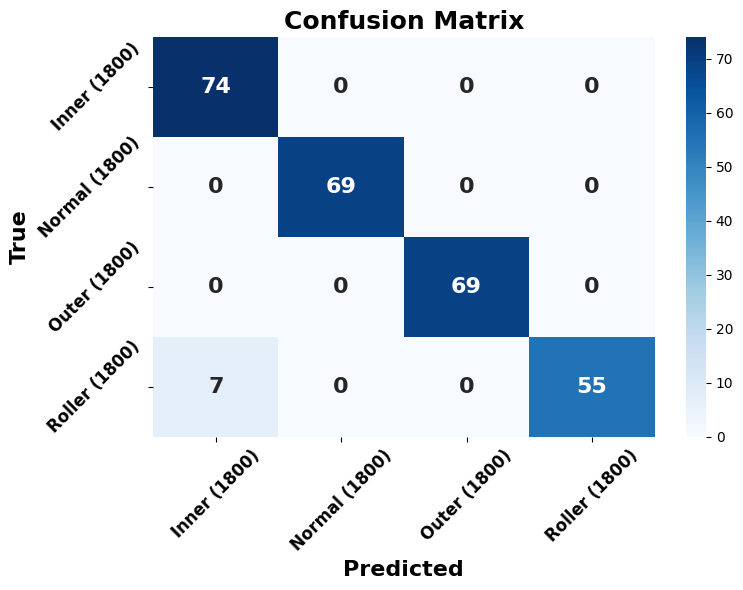

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
labels = full_dataset.classes

# Plot
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels,
            annot_kws={"size": 16, "weight": "bold"})
plt.title("Confusion Matrix", fontsize=18, fontweight='bold')
plt.xlabel("Predicted", fontsize=16, fontweight='bold')
plt.ylabel("True", fontsize=16, fontweight='bold')
plt.xticks(fontsize=12, weight='bold', rotation=45)
plt.yticks(fontsize=12, weight='bold', rotation=45)
plt.tight_layout()
plt.show()


✅ Features Shape for t-SNE: (274, 128)


c:\Users\Muhammad Umar\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


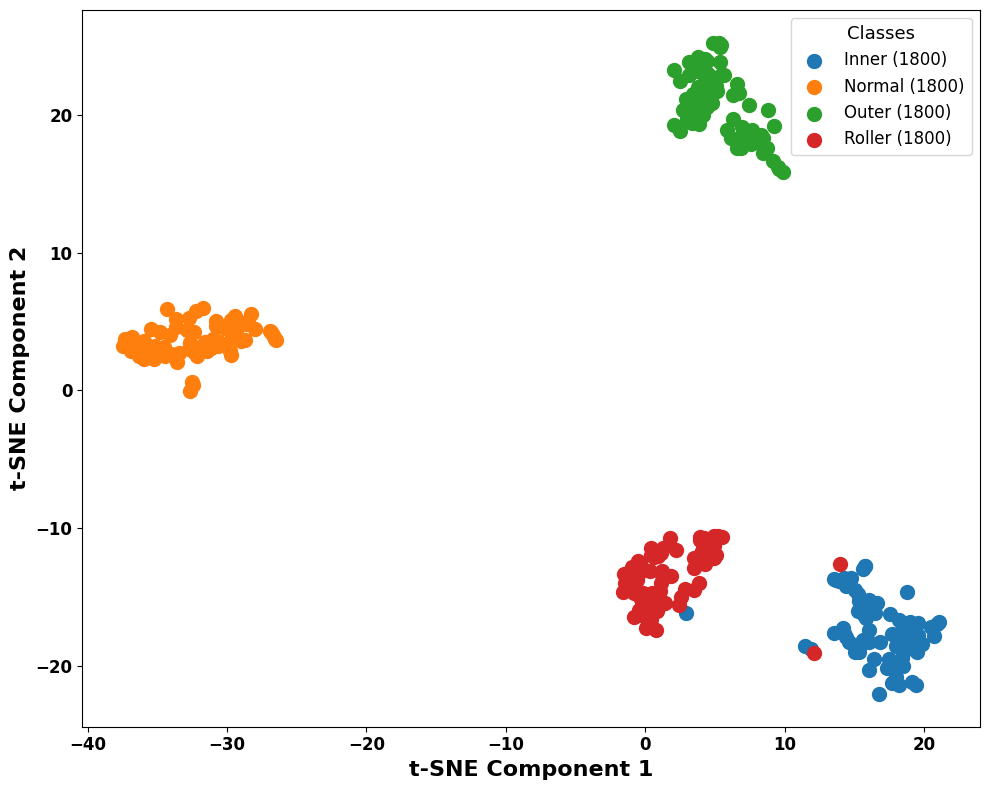

In [5]:
from sklearn.manifold import TSNE
import numpy as np

# Extract features before the classifier layer
model.eval()
features, tsne_labels = [], []

with torch.no_grad():
    for batch_X, batch_y in val_loader:
        batch_X = batch_X.to(device)

        x = batch_X.squeeze(1)          # (B, 128, 128)
        x = model.embedding(x)          # (B, 128, 128)
        x, _ = model.mhsa(x, x, x)      # (B, 128, 128)
        x, _ = model.bilstm(x)          # (B, 128, 128)
        x = x.mean(dim=1)               # (B, 128)
        features.append(x.cpu().numpy())
        tsne_labels.extend(batch_y.cpu().numpy())

features_np = np.concatenate(features, axis=0)
tsne_labels = np.array(tsne_labels)
print("✅ Features Shape for t-SNE:", features_np.shape)

# Apply t-SNE
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, n_iter=1000, random_state=42)
features_2d = tsne.fit_transform(features_np)

# Plot t-SNE
plt.figure(figsize=(10, 8))
palette = sns.color_palette("tab10", len(set(tsne_labels)))

for i, label in enumerate(np.unique(tsne_labels)):
    idx = tsne_labels == label
    plt.scatter(
        features_2d[idx, 0], features_2d[idx, 1],
        label=full_dataset.classes[label],
        s=100
    )


plt.xlabel("t-SNE Component 1", fontsize=16, fontweight='bold')
plt.ylabel("t-SNE Component 2", fontsize=16, fontweight='bold')
plt.legend(title="Classes", fontsize=12, title_fontsize=13)

plt.xticks(fontsize=12, weight='bold')
plt.yticks(fontsize=12, weight='bold')
plt.tight_layout()

plt.show()


In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import classification_report, accuracy_score

# Configuration
data_dir = r"E:\Collaboration Work\With Farooq\Bearings MDPI\CWT_Log\For Channel-02"
batch_size = 32
num_epochs = 40
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Transforms
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

# Load Data
full_dataset = datasets.ImageFolder(data_dir, transform=transform)
targets = [label for _, label in full_dataset.samples]

splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_idx, val_idx in splitter.split(torch.zeros(len(targets)), targets):
    train_dataset = Subset(full_dataset, train_idx)
    val_dataset = Subset(full_dataset, val_idx)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Model: Conv1D-Only
class Conv1DOnlyModel(nn.Module):
    def __init__(self, num_classes=4):
        super(Conv1DOnlyModel, self).__init__()
        self.conv_block = nn.Sequential(
            nn.Conv1d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
            nn.Conv1d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):  # x: (B, 1, 128, 128)
        x = x.squeeze(1)  # (B, 128, 128)
        x = x.permute(0, 2, 1)  # (B, 128, 128)
        x = self.conv_block(x)  # (B, 128, 1)
        x = x.squeeze(-1)  # (B, 128)
        return self.classifier(x)  # (B, num_classes)

# Initialize Model
model = Conv1DOnlyModel(num_classes=len(full_dataset.classes)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

# Training Loop
for epoch in range(num_epochs):
    model.train()
    total_loss, correct, total = 0.0, 0, 0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == batch_y).sum().item()
        total += batch_y.size(0)
    train_acc = 100 * correct / total
    scheduler.step()
    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {total_loss:.4f}, Train Acc: {train_acc:.2f}%")

# Evaluation
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for batch_X, batch_y in val_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        outputs = model(batch_X)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(batch_y.cpu().numpy())

acc = accuracy_score(all_labels, all_preds)
print(f"\n✅ Final Validation Accuracy: {acc * 100:.2f}%")
print("\n=== Classification Report ===")
print(classification_report(all_labels, all_preds, target_names=full_dataset.classes))



Epoch [1/40] - Train Loss: 48.6483, Train Acc: 24.73%
Epoch [2/40] - Train Loss: 48.3258, Train Acc: 29.93%
Epoch [3/40] - Train Loss: 47.5194, Train Acc: 34.31%
Epoch [4/40] - Train Loss: 46.0852, Train Acc: 35.86%
Epoch [5/40] - Train Loss: 45.3306, Train Acc: 37.23%
Epoch [6/40] - Train Loss: 44.9208, Train Acc: 38.59%
Epoch [7/40] - Train Loss: 43.5261, Train Acc: 40.97%
Epoch [8/40] - Train Loss: 41.3400, Train Acc: 45.99%
Epoch [9/40] - Train Loss: 37.7720, Train Acc: 50.64%
Epoch [10/40] - Train Loss: 35.4450, Train Acc: 53.74%
Epoch [11/40] - Train Loss: 32.8417, Train Acc: 55.38%
Epoch [12/40] - Train Loss: 31.4005, Train Acc: 60.13%
Epoch [13/40] - Train Loss: 30.1871, Train Acc: 61.04%
Epoch [14/40] - Train Loss: 29.1455, Train Acc: 62.14%
Epoch [15/40] - Train Loss: 28.7093, Train Acc: 64.14%
Epoch [16/40] - Train Loss: 28.4490, Train Acc: 63.59%
Epoch [17/40] - Train Loss: 27.0134, Train Acc: 66.42%
Epoch [18/40] - Train Loss: 26.1554, Train Acc: 67.97%
Epoch [19/40] - Tra

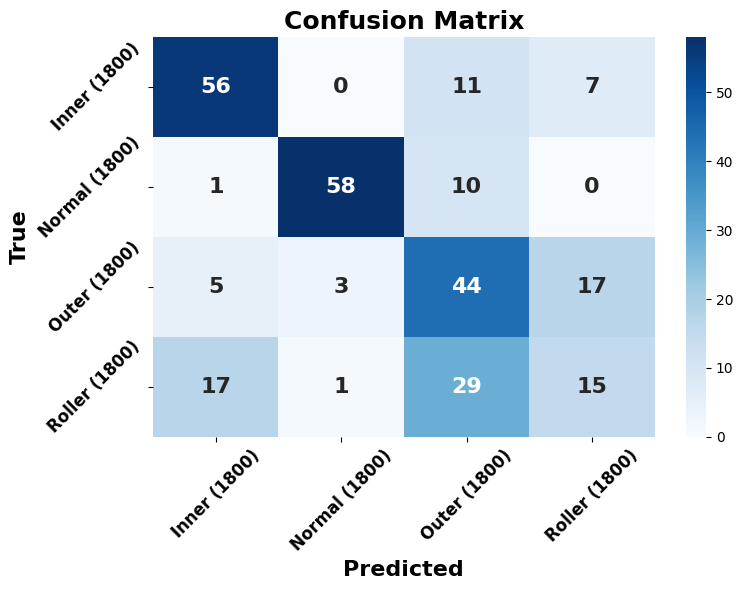

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)
labels = full_dataset.classes

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels,
            annot_kws={"size": 16, "weight": "bold"})

plt.title("Confusion Matrix", fontsize=18, fontweight='bold')
plt.xlabel("Predicted", fontsize=16, fontweight='bold')
plt.ylabel("True", fontsize=16, fontweight='bold')
plt.xticks(fontsize=12, weight='bold', rotation=45)
plt.yticks(fontsize=12, weight='bold', rotation=45)
plt.tight_layout()
plt.show()


✅ Feature shape for t-SNE: (274, 128)


c:\Users\Muhammad Umar\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


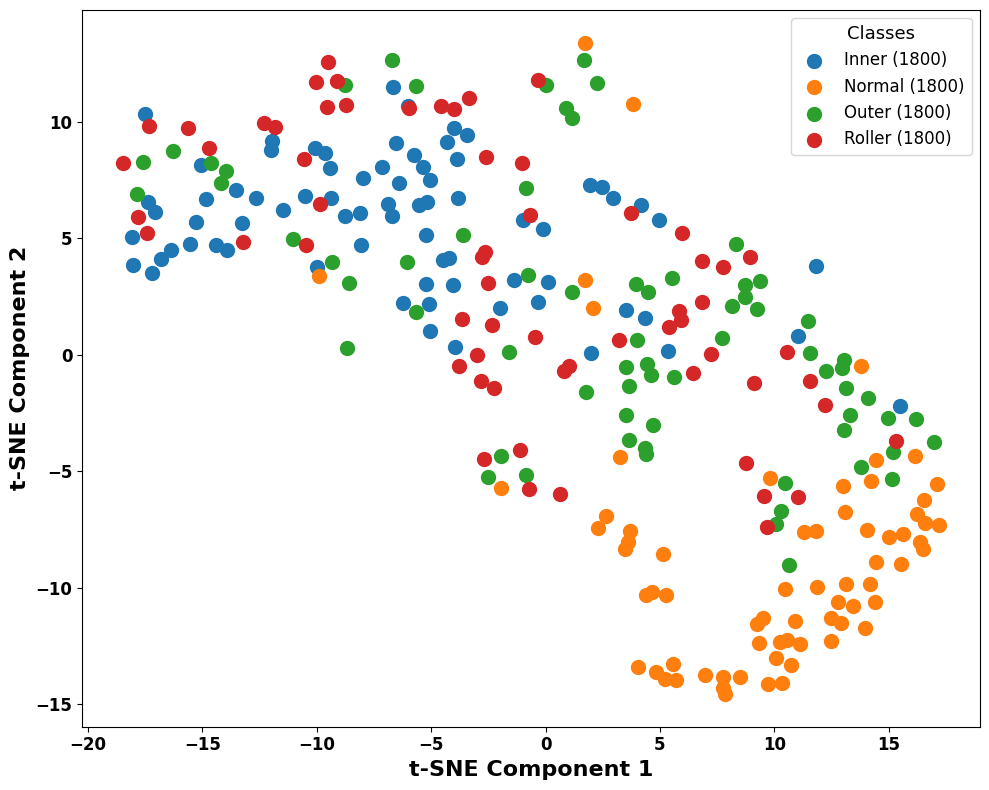

In [9]:
from sklearn.manifold import TSNE
import numpy as np

# Extract intermediate features (just before classifier)
model.eval()
features, tsne_labels = [], []

with torch.no_grad():
    for batch_X, batch_y in val_loader:
        batch_X = batch_X.to(device)

        # Forward up to conv_block
        x = batch_X.squeeze(1)          # (B, 128, 128)
        x = x.permute(0, 2, 1)          # (B, 128, 128)
        x = model.conv_block(x)         # (B, 128, 1)
        x = x.squeeze(-1)               # (B, 128)
        features.append(x.cpu().numpy())
        tsne_labels.extend(batch_y.cpu().numpy())

features_np = np.concatenate(features, axis=0)
tsne_labels = np.array(tsne_labels)

print("✅ Feature shape for t-SNE:", features_np.shape)

# Fit t-SNE
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, n_iter=1000, random_state=42)
features_2d = tsne.fit_transform(features_np)

# Plot t-SNE
plt.figure(figsize=(10, 8))
palette = sns.color_palette("tab10", len(set(tsne_labels)))

for i, label in enumerate(np.unique(tsne_labels)):
    idx = tsne_labels == label
    plt.scatter(features_2d[idx, 0], features_2d[idx, 1],
                label=full_dataset.classes[label], s=100)


plt.xlabel("t-SNE Component 1", fontsize=16, fontweight='bold')
plt.ylabel("t-SNE Component 2", fontsize=16, fontweight='bold')
plt.legend(title="Classes", fontsize=12, title_fontsize=13)

plt.xticks(fontsize=12, weight='bold')
plt.yticks(fontsize=12, weight='bold')
plt.tight_layout()

plt.show()
